In [1]:
import numpy as np
import matplotlib.pyplot as plt

def heat_equation_three_level_solver(alpha=1.0, k=1.0, L=10.0, T0=100.0, Nx=50, Nt=1000, dt=0.01, d=0.5,
                                    left_bc_type='fixed', right_bc_type='fixed',
                                    left_bc_value=0.0, right_bc_value=0.0, num_terms=10):
    """
    Solves the 1D heat equation using a three-level scheme which is availabe on the problem 1 of set 3 in github, computes boundary fluxes, and compares with analytical solution.

    Parameters:
    -----------
    alpha : float
        Diffusion coefficient (m²/s)
    k : float
        Thermal conductivity (W/m·K)
    L : float
        Length of the domain (m)
    T0 : float
        Initial temperature (°C)
    Nx : int
        Number of spatial grid points
    Nt : int
        Number of time steps
    dt : float
        Time step size (s)
    d : float
        Parameter for the three-level scheme
    left_bc_type : str
        Boundary condition at x=0 ('fixed' or 'insulated')
    right_bc_type : str
        Boundary condition at x=L ('fixed' or 'insulated')
    left_bc_value : float
        Boundary value at x=0 (temperature for fixed, flux for insulated)
    right_bc_value : float
        Boundary value at x=L (temperature for fixed, flux for insulated)
    num_terms : int
        Number of Fourier terms for analytical solution

    Returns:
    --------
    dict
        Contains:
        - x: numpy array of spatial grid points
        - T_three_level: numpy array of temperatures (Nx x Nt)
        - q_three_level: dict with 'left' and 'right' boundary fluxes (arrays of length Nt)
    """
    dx = L / (Nx - 1)

    if dt > dx**2 / (2 * alpha):
        print(f"Warning: Time step {dt} too large for stability! Adjusting to {dx**2 / (2 * alpha)}")
        dt = dx**2 / (2 * alpha)

    x = np.linspace(0, L, Nx)
    t = np.linspace(0, Nt * dt, Nt)

    T = np.zeros((Nx, Nt))
    T[:, 0] = T0

    q_left = np.zeros(Nt)
    q_right = np.zeros(Nt)

    if left_bc_type == 'fixed':
        T[0, 0] = left_bc_value
    elif left_bc_type == 'insulated':
        T[0, 0] = T[1, 0]

    if right_bc_type == 'fixed':
        T[-1, 0] = right_bc_value
    elif right_bc_type == 'insulated':
        T[-1, 0] = T[-2, 0]

    def analytical_solution_with_boundaries(x, t, T0, left_bc_type, right_bc_type,
                                           left_bc_value, right_bc_value, alpha, L, num_terms):
        if left_bc_type == 'fixed' and right_bc_type == 'fixed':
            T_steady = left_bc_value + (right_bc_value - left_bc_value) * x / L
        elif left_bc_type == 'insulated' and right_bc_type == 'insulated':
            T_steady = np.full_like(x, T0)
        elif left_bc_type == 'insulated':
            T_steady = right_bc_value * np.ones_like(x)
        else:
            T_steady = left_bc_value * np.ones_like(x)

        T_initial_adjusted = np.full_like(x, T0) - T_steady

        T_transient = np.zeros_like(x)
        for n in range(1, num_terms * 2, 2):
            if left_bc_type == 'insulated':
                bn = 2/L * np.trapezoid(T_initial_adjusted * np.cos(n * np.pi * x / L), x)
                T_transient += bn * np.cos(n * np.pi * x / L) * np.exp(-alpha * (n * np.pi / L)**2 * t)
            else:
                bn = 2/L * np.trapezoid(T_initial_adjusted * np.sin(n * np.pi * x / L), x)
                T_transient += bn * np.sin(n * np.pi * x / L) * np.exp(-alpha * (n * np.pi / L)**2 * t)

        return T_steady + T_transient

    T[:, 1] = analytical_solution_with_boundaries(x, dt, T0, left_bc_type, right_bc_type,
                                                 left_bc_value, right_bc_value, alpha, L, num_terms)

    if left_bc_type == 'fixed':
        T[0, 1] = left_bc_value
    elif left_bc_type == 'insulated':
        T[0, 1] = T[1, 1]

    if right_bc_type == 'fixed':
        T[-1, 1] = right_bc_value
    elif right_bc_type == 'insulated':
        T[-1, 1] = T[-2, 1]

    if left_bc_type == 'fixed':
        q_left[0:2] = -k * (T[1, 0:2] - T[0, 0:2]) / dx
    elif left_bc_type == 'insulated':
        q_left[0:2] = left_bc_value

    if right_bc_type == 'fixed':
        q_right[0:2] = -k * (T[-1, 0:2] - T[-2, 0:2]) / dx
    elif right_bc_type == 'insulated':
        q_right[0:2] = right_bc_value

    for n in range(1, Nt-1):
        for j in range(1, Nx-1):
            diffusion_n = (T[j-1, n] - 2*T[j, n] + T[j+1, n]) / dx**2
            diffusion_nm1 = (T[j-1, n-1] - 2*T[j, n-1] + T[j+1, n-1]) / dx**2
            T[j, n+1] = (1/1.5) * (2*T[j, n] - 0.5*T[j, n-1] +
                                  alpha * dt * ((1+d)*diffusion_n - d*diffusion_nm1))

        if left_bc_type == 'fixed':
            T[0, n+1] = left_bc_value
        elif left_bc_type == 'insulated':
            T[0, n+1] = T[1, n+1]

        if right_bc_type == 'fixed':
            T[-1, n+1] = right_bc_value
        elif right_bc_type == 'insulated':
            T[-1, n+1] = T[-2, n+1]

        if left_bc_type == 'fixed':
            q_left[n+1] = -k * (T[1, n+1] - T[0, n+1]) / dx
        elif left_bc_type == 'insulated':
            q_left[n+1] = left_bc_value

        if right_bc_type == 'fixed':
            q_right[n+1] = -k * (T[-1, n+1] - T[-2, n+1]) / dx
        elif right_bc_type == 'insulated':
            q_right[n+1] = right_bc_value

    plt.figure(figsize=(12, 8), dpi=300)
    num_time_points = 10
    time_points = np.linspace(0, Nt-1, num_time_points, dtype=int)
    colors = plt.cm.viridis(np.linspace(0, 1, num_time_points))

    for i, n in enumerate(time_points):
        time_label = f"t = {n*dt:.2f}s"
        analytical = analytical_solution_with_boundaries(x, n*dt, T0, left_bc_type, right_bc_type,
                                                        left_bc_value, right_bc_value, alpha, L, num_terms)
        plt.plot(x, analytical, color=colors[i], linestyle='-', alpha=0.7,
                 label=f"Analytical ({time_label})")
        plt.plot(x, T[:, n], color=colors[i], linestyle='--', linewidth=3.0,
                 label=f"Numerical ({time_label})")

    plt.title("Temperature Distribution Over Time: Numerical vs Analytical", fontsize=14)
    plt.xlabel("Position (x)", fontsize=12)
    plt.ylabel("Temperature (T)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)
    plt.grid(True)
    plt.savefig('heat_equation_comparison.png', dpi=300)

    return T, q_left, q_right, x

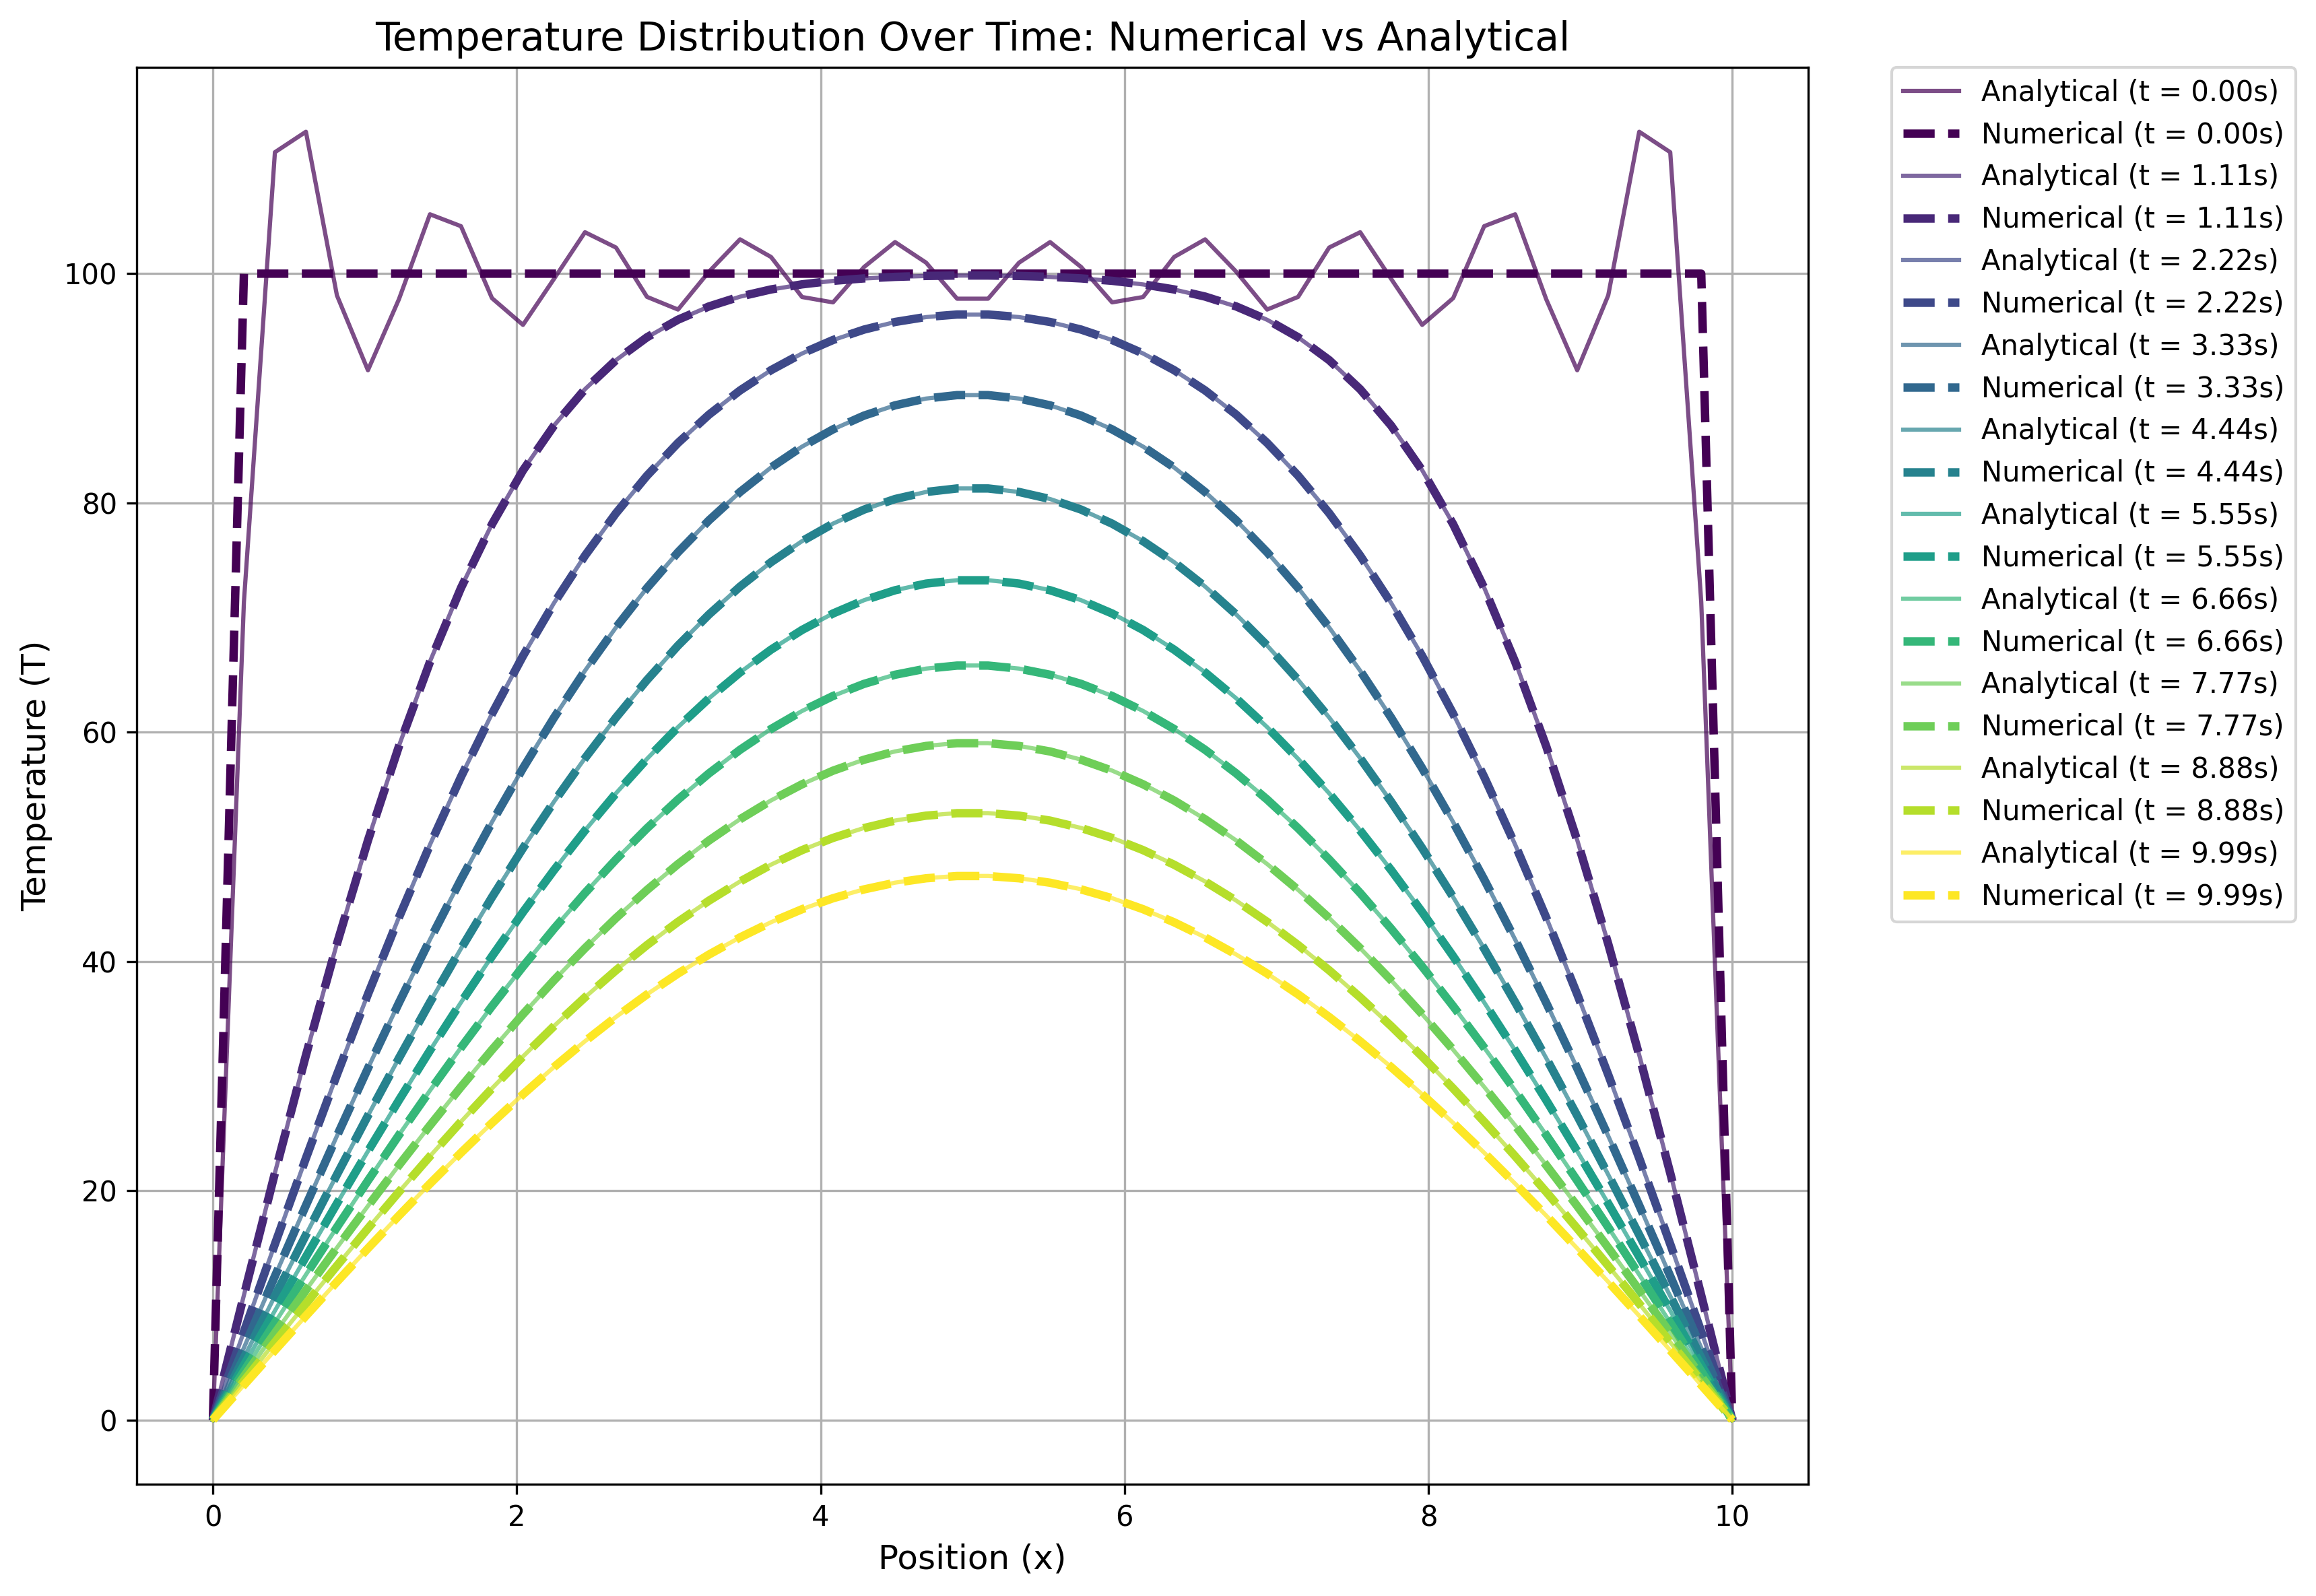

In [2]:
# Problem 1
T_three_level, q_three_level_left, q_three_level_right, x = heat_equation_three_level_solver(
    alpha=1.0, k=1.0, L=10.0, T0=100.0, Nx=50, Nt=1000, dt=0.01, d=0.5,
    left_bc_type='fixed', right_bc_type='fixed',
    left_bc_value=0.0, right_bc_value=0.0, num_terms=10
)

In [3]:
from tabulate import tabulate

def laasonen_solver(L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
                    left_bc_value=None, right_bc_value=None):
    """
    Solves 1D heat conduction using the Implicit Laasonen method.

    Parameters:
    -----------
    L : float
        Length of the slab (m)
    alpha : float
        Thermal diffusivity (m²/s)
    k : float
        Thermal conductivity (W/(m·°C))
    dx : float
        Spatial step size (m)
    r : float
        Dimensionless parameter r = α·dt/dx²
    T_initial : float or array
        Initial temperature (°C)
    time_steps : int
        Number of time steps
    left_bc_type : str
        'insulated', 'fixed', or 'flux' for x=0
    right_bc_type : str
        'insulated', 'fixed', or 'flux' for x=L
    left_bc_value : float, optional
        Temperature at x=0 if 'fixed', or heat flux (W/m²) if 'flux'
    right_bc_value : float, optional
        Temperature at x=L if 'fixed', or heat flux (W/m²) if 'flux'

    Returns:
    --------
    T : array
        Temperature distribution (nodes x time_steps+1)
    q_flux_left : array
        Heat flux at x=0 (W/m²)
    q_flux_right : array
        Heat flux at x=L (W/m²)
    x : array
        Spatial grid (m)
    dt : float
        Time step (s)
    """
    dt = r * dx**2 / alpha

    nodes = int(L / dx) + 1
    x = np.linspace(0, L, nodes)

    T = np.zeros((nodes, time_steps + 1))
    if isinstance(T_initial, (int, float)):
        T[:, 0] = T_initial
    else:
        T[:, 0] = T_initial

    if left_bc_type == 'fixed' and left_bc_value is not None:
        T[0, 0] = left_bc_value
    if right_bc_type == 'fixed' and right_bc_value is not None:
        T[-1, 0] = right_bc_value

    q_flux_left = np.zeros(time_steps + 1)
    q_flux_right = np.zeros(time_steps + 1)

    A = np.zeros((nodes, nodes))
    for i in range(nodes):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i-1] = -r
        if i < nodes - 1:
            A[i, i+1] = -r

    if left_bc_type == 'insulated':
        A[0, 0] = 3
        A[0, 1] = -2
    elif left_bc_type == 'fixed':
        A[0, :] = 0
        A[0, 0] = 1
    elif left_bc_type == 'flux':
        A[0, 0] = 1 + r
        A[0, 1] = -r

    if right_bc_type == 'fixed':
        A[-1, :] = 0
        A[-1, -1] = 1
    elif right_bc_type == 'insulated':
        A[-1, -1] = 3
        A[-1, -2] = -2
    elif right_bc_type == 'flux':
        A[-1, -1] = 1 + r
        A[-1, -2] = -r

    for n in range(1, time_steps + 1):
        b = np.copy(T[:, n-1])

        if left_bc_type == 'fixed':
            b[0] = left_bc_value
        elif left_bc_type == 'flux' and left_bc_value is not None:
            b[0] = b[0] - (left_bc_value * dx) / k

        if right_bc_type == 'fixed':
            b[-1] = right_bc_value
        elif right_bc_type == 'flux' and right_bc_value is not None:
            b[-1] = b[-1] + (right_bc_value * dx) / k

        T[:, n] = np.linalg.solve(A, b)

        if left_bc_type == 'insulated':
            q_flux_left[n] = 0
        elif left_bc_type == 'flux':
            q_flux_left[n] = left_bc_value
        else:
            q_flux_left[n] = -k * (T[1, n] - T[0, n]) / dx

        if right_bc_type == 'insulated':
            q_flux_right[n] = 0
        elif right_bc_type == 'flux':
            q_flux_right[n] = right_bc_value
        else:
            q_flux_right[n] = -k * (T[-1, n] - T[-2, n]) / dx

    return T, q_flux_left, q_flux_right, x, dt

def dufort_frankel_solver(L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
                          left_bc_value=None, right_bc_value=None):
    """
    Solves 1D heat conduction using the Explicit DuFort-Frankel method with modified FTCS initialization.

    Parameters:
    -----------
    Same as laasonen_solver.

    Returns:
    --------
    Same as laasonen_solver.
    """
    dt = r * dx**2 / alpha

    r_ftcs = 0.5
    dt_ftcs = r_ftcs * dx**2 / alpha

    nodes = int(L / dx) + 1
    x = np.linspace(0, L, nodes)

    T = np.zeros((nodes, time_steps + 1))
    if isinstance(T_initial, (int, float)):
        T[:, 0] = T_initial
    else:
        T[:, 0] = T_initial

    if left_bc_type == 'fixed' and left_bc_value is not None:
        T[0, 0] = left_bc_value
    if right_bc_type == 'fixed' and right_bc_value is not None:
        T[-1, 0] = right_bc_value

    q_flux_left = np.zeros(time_steps + 1)
    q_flux_right = np.zeros(time_steps + 1)

    for i in range(1, nodes-1):
        T[i, 1] = T[i, 0] + r_ftcs * (T[i+1, 0] - 2 * T[i, 0] + T[i-1, 0])

    if left_bc_type == 'insulated':
        T[0, 1] = T[0, 0] + r_ftcs * (T[1, 0] - 2 * T[0, 0] + T[1, 0])
    elif left_bc_type == 'fixed':
        T[0, 1] = left_bc_value
    elif left_bc_type == 'flux':
        T[0, 1] = T[1, 1] + (left_bc_value * dx) / k

    if right_bc_type == 'fixed':
        T[-1, 1] = right_bc_value
    elif right_bc_type == 'insulated':
        T[-1, 1] = (4*T[-2, 1] - T[-3, 1])/3
    elif right_bc_type == 'flux':
        T[-1, 1] = T[-2, 1] - (right_bc_value * dx) / k

    if left_bc_type == 'insulated':
        q_flux_left[1] = 0
    elif left_bc_type == 'flux':
        q_flux_left[1] = left_bc_value
    else:
        q_flux_left[1] = -k * (T[1, 1] - T[0, 1]) / dx

    if right_bc_type == 'insulated':
        q_flux_right[1] = 0
    elif right_bc_type == 'flux':
        q_flux_right[1] = right_bc_value
    else:
        q_flux_right[1] = -k * (T[-1, 1] - T[-2, 1]) / dx

    for n in range(2, time_steps + 1):
        for i in range(1, nodes-1):
            T[i, n] = ((1 - 2*r) * T[i, n-2] + 2*r * (T[i+1, n-1] + T[i-1, n-1])) / (1 + 2*r)

        if left_bc_type == 'insulated':
            T[0, n] = ((1 - 2*r) * T[0, n-2] + 2*r * (T[1, n-1] + T[1, n-1])) / (1 + 2*r)
        elif left_bc_type == 'fixed':
            T[0, n] = left_bc_value
        elif left_bc_type == 'flux':
            T[0, n] = T[1, n] + (left_bc_value * dx) / k

        if right_bc_type == 'fixed':
            T[-1, n] = right_bc_value
        elif right_bc_type == 'insulated':
            T[-1, n] = (4*T[-2, n] - T[-3, n])/3
        elif right_bc_type == 'flux':
            T[-1, n] = T[-2, n] - (right_bc_value * dx) / k

        if left_bc_type == 'insulated':
            q_flux_left[n] = 0
        elif left_bc_type == 'flux':
            q_flux_left[n] = left_bc_value
        else:
            q_flux_left[n] = -k * (T[1, n] - T[0, n]) / dx

        if right_bc_type == 'insulated':
            q_flux_right[n] = 0
        elif right_bc_type == 'flux':
            q_flux_right[n] = right_bc_value
        else:
            q_flux_right[n] = -k * (T[-1, n] - T[-2, n]) / dx

    return T, q_flux_left, q_flux_right, x, dt

def print_table(T, q_flux_left, q_flux_right, x, method_name, time_steps=None):
    """
    Prints temperature distribution and heat flux in a table.

    Parameters:
    -----------
    T : array
        Temperature distribution
    q_flux_left : array
        Heat flux at x=0
    q_flux_right : array
        Heat flux at x=L
    x : array
        Spatial grid (m)
    method_name : str
        Name of the method
    time_steps : list, optional
        Time steps to display
    """
    if time_steps is None:
        time_steps = range(T.shape[1])

    x_cm = x * 100
    headers = ["Node", "Position (cm)"] + [f"i = {i} (°C)" for i in time_steps]
    table_data = [[i, f"{x_cm[i]:.1f}"] + [f"{T[i, step]:.2f}" for step in time_steps]
                  for i in range(len(x))]

    print(f"\nTemperature Distribution - {method_name}:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"\nHeat Flux at x=0 (W/m²) - {method_name}:")
    for step in time_steps:
        if step > 0:
            print(f"i = {step}: {q_flux_left[step]:.2f}")

    print(f"\nHeat Flux at x=L (W/m²) - {method_name}:")
    for step in time_steps:
        if step > 0:
            print(f"i = {step}: {q_flux_right[step]:.2f}")

Delta t is 25.000000000000004 seconds

Temperature Distribution - Implicit Laasonen Method:
+--------+-----------------+--------------+--------------+--------------+--------------+
|   Node |   Position (cm) |   i = 0 (°C) |   i = 1 (°C) |   i = 2 (°C) |   i = 3 (°C) |
+========+=================+==============+==============+==============+==============+
|      0 |             0   |          200 |       191.49 |       176.28 |       158.15 |
+--------+-----------------+--------------+--------------+--------------+--------------+
|      1 |             0.5 |          200 |       187.23 |       168.67 |       149.08 |
+--------+-----------------+--------------+--------------+--------------+--------------+
|      2 |             1   |          200 |       170.21 |       142.51 |       120.43 |
+--------+-----------------+--------------+--------------+--------------+--------------+
|      3 |             1.5 |          200 |       123.4  |        88.64 |        69.69 |
+--------+--------

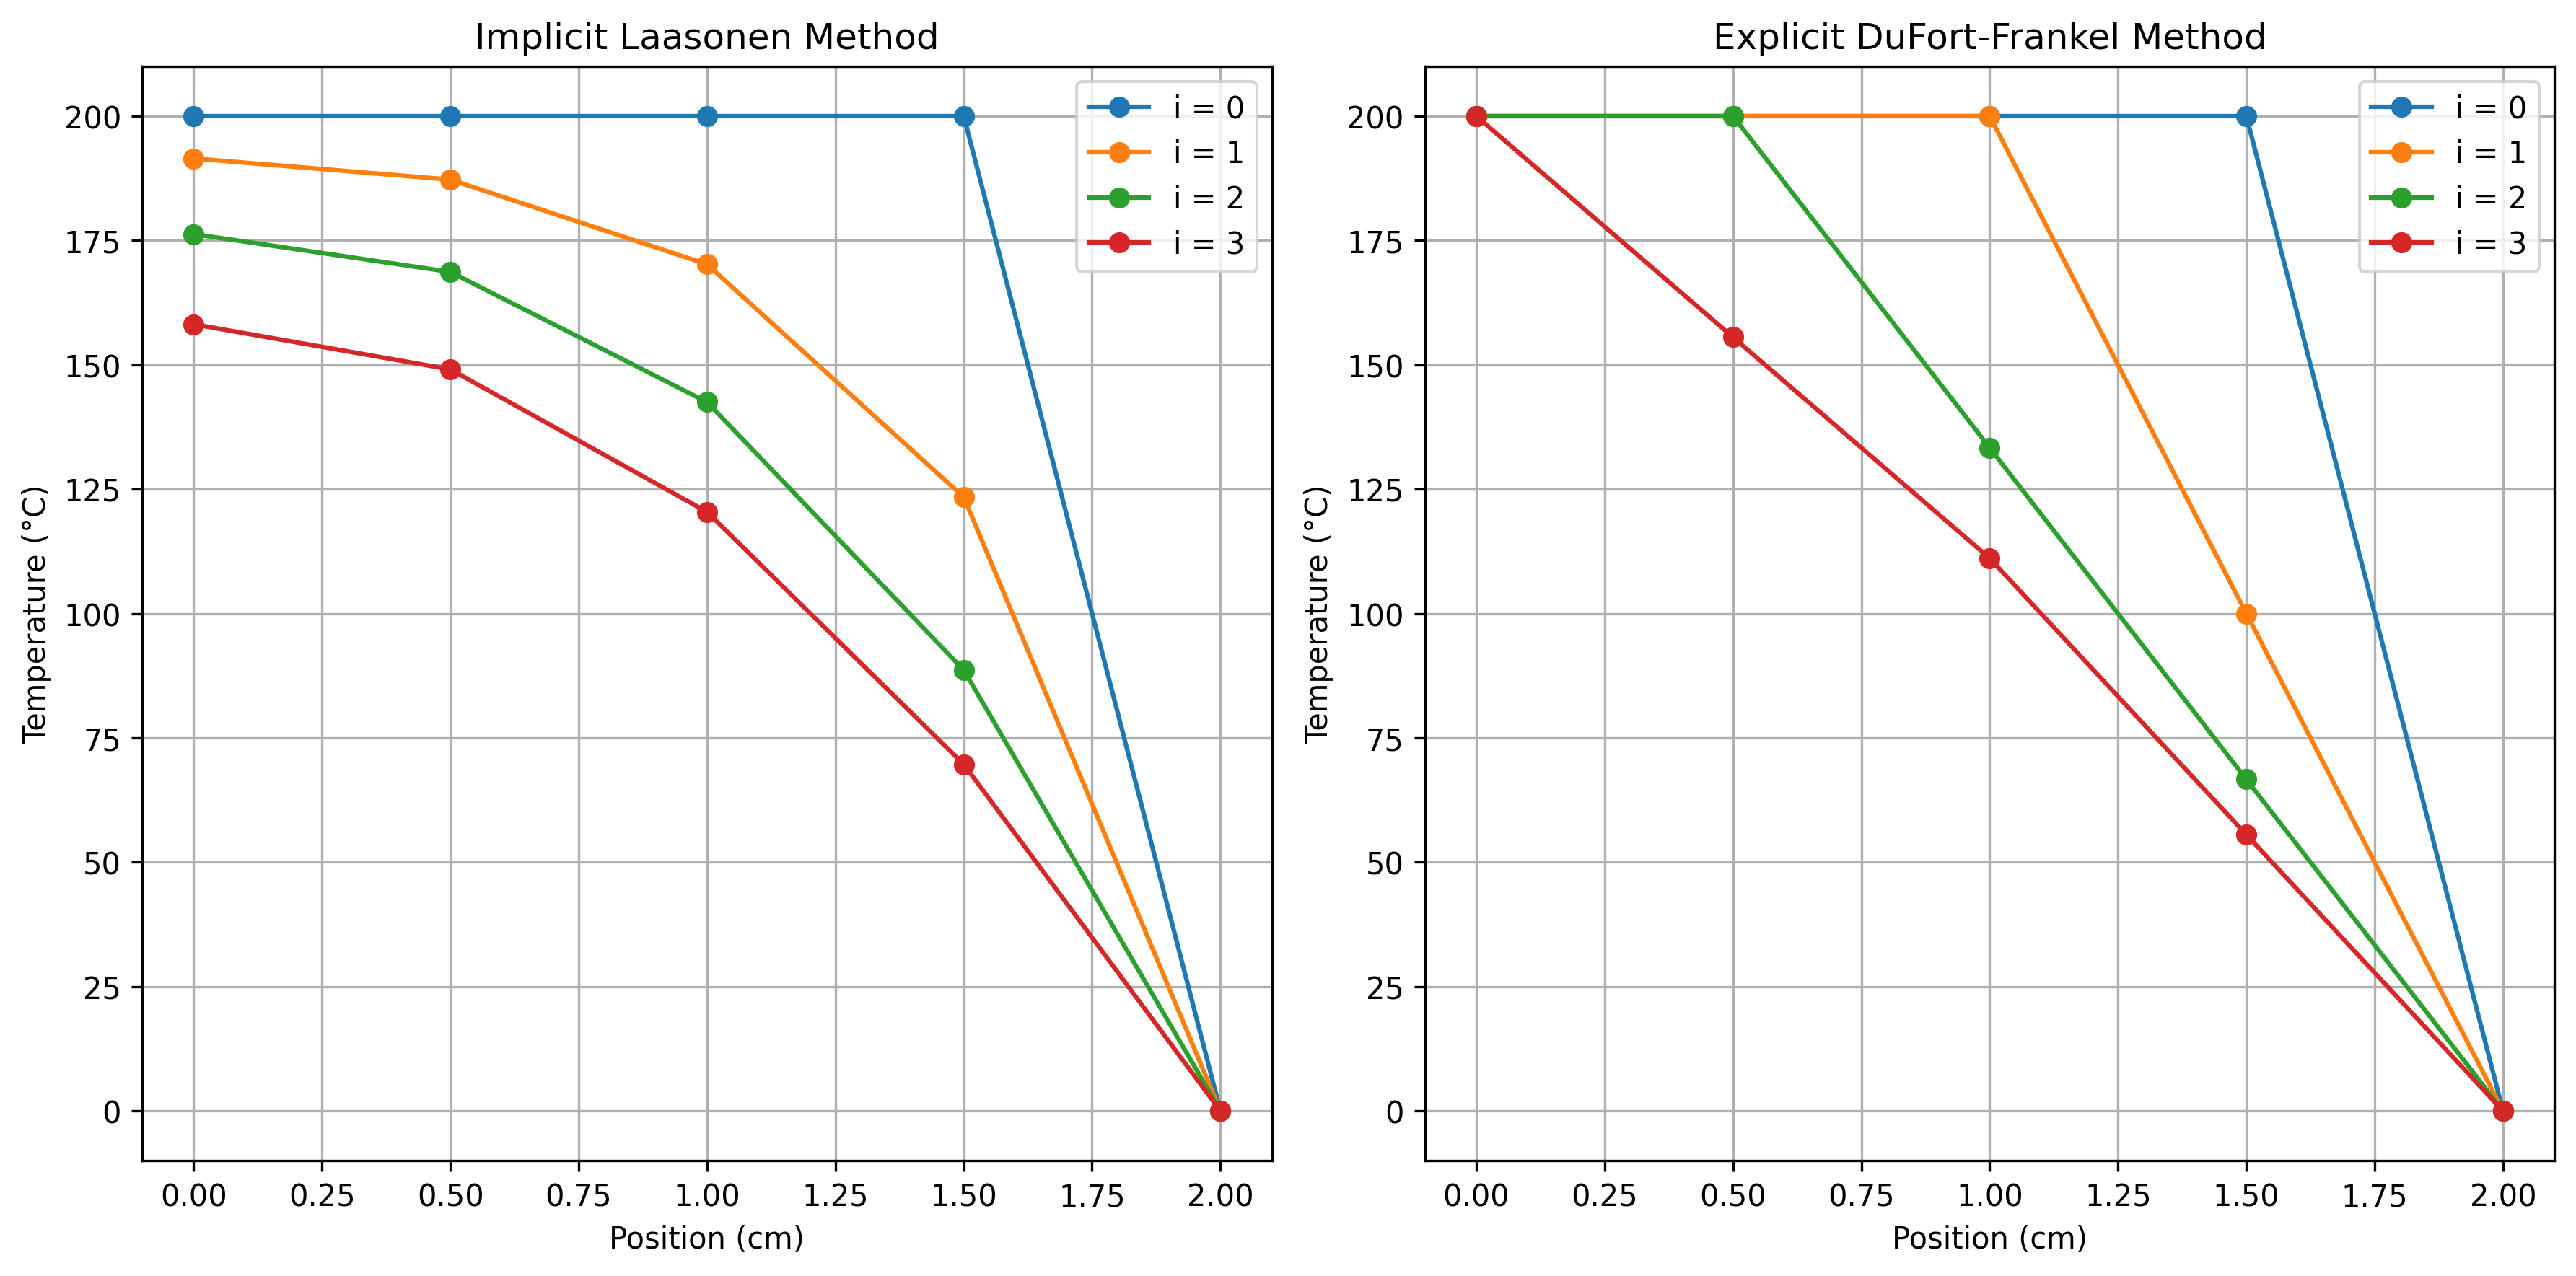

In [4]:
# Parameters for problem 2
L = 0.02
alpha = 1e-6
k = 2
dx = 0.005
r = 1.0
T_initial = 200
time_steps = 3

left_bc_type = 'insulated'
right_bc_type = 'fixed'
right_bc_value = 0

delta_t = (r * dx**2) / alpha
print(f"Delta t is {delta_t} seconds")

T_laasonen, q_left_laasonen, q_right_laasonen, x, dt = laasonen_solver(
    L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
    right_bc_value=right_bc_value
)
print_table(T_laasonen, q_left_laasonen, q_right_laasonen, x, "Implicit Laasonen Method", range(4))

T_dufort, q_left_dufort, q_right_dufort, x, dt = dufort_frankel_solver(
    L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
    right_bc_value=right_bc_value
)
print_table(T_dufort, q_left_dufort, q_right_dufort, x, "Explicit DuFort-Frankel Method", range(4))

plt.figure(figsize=(12, 6), dpi=300)

for i in range(4):
    plt.subplot(1, 2, 1)
    plt.plot(x*100, T_laasonen[:, i], marker='o', label=f'i = {i}')
plt.title('Implicit Laasonen Method')
plt.xlabel('Position (cm)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

for i in range(4):
    plt.subplot(1, 2, 2)
    plt.plot(x*100, T_dufort[:, i], marker='o', label=f'i = {i}')
plt.title('Explicit DuFort-Frankel Method')
plt.xlabel('Position (cm)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('temperature_profiles_comparison_for_problem2.png', dpi=300)
plt.show()

Delta t is 0.01 seconds


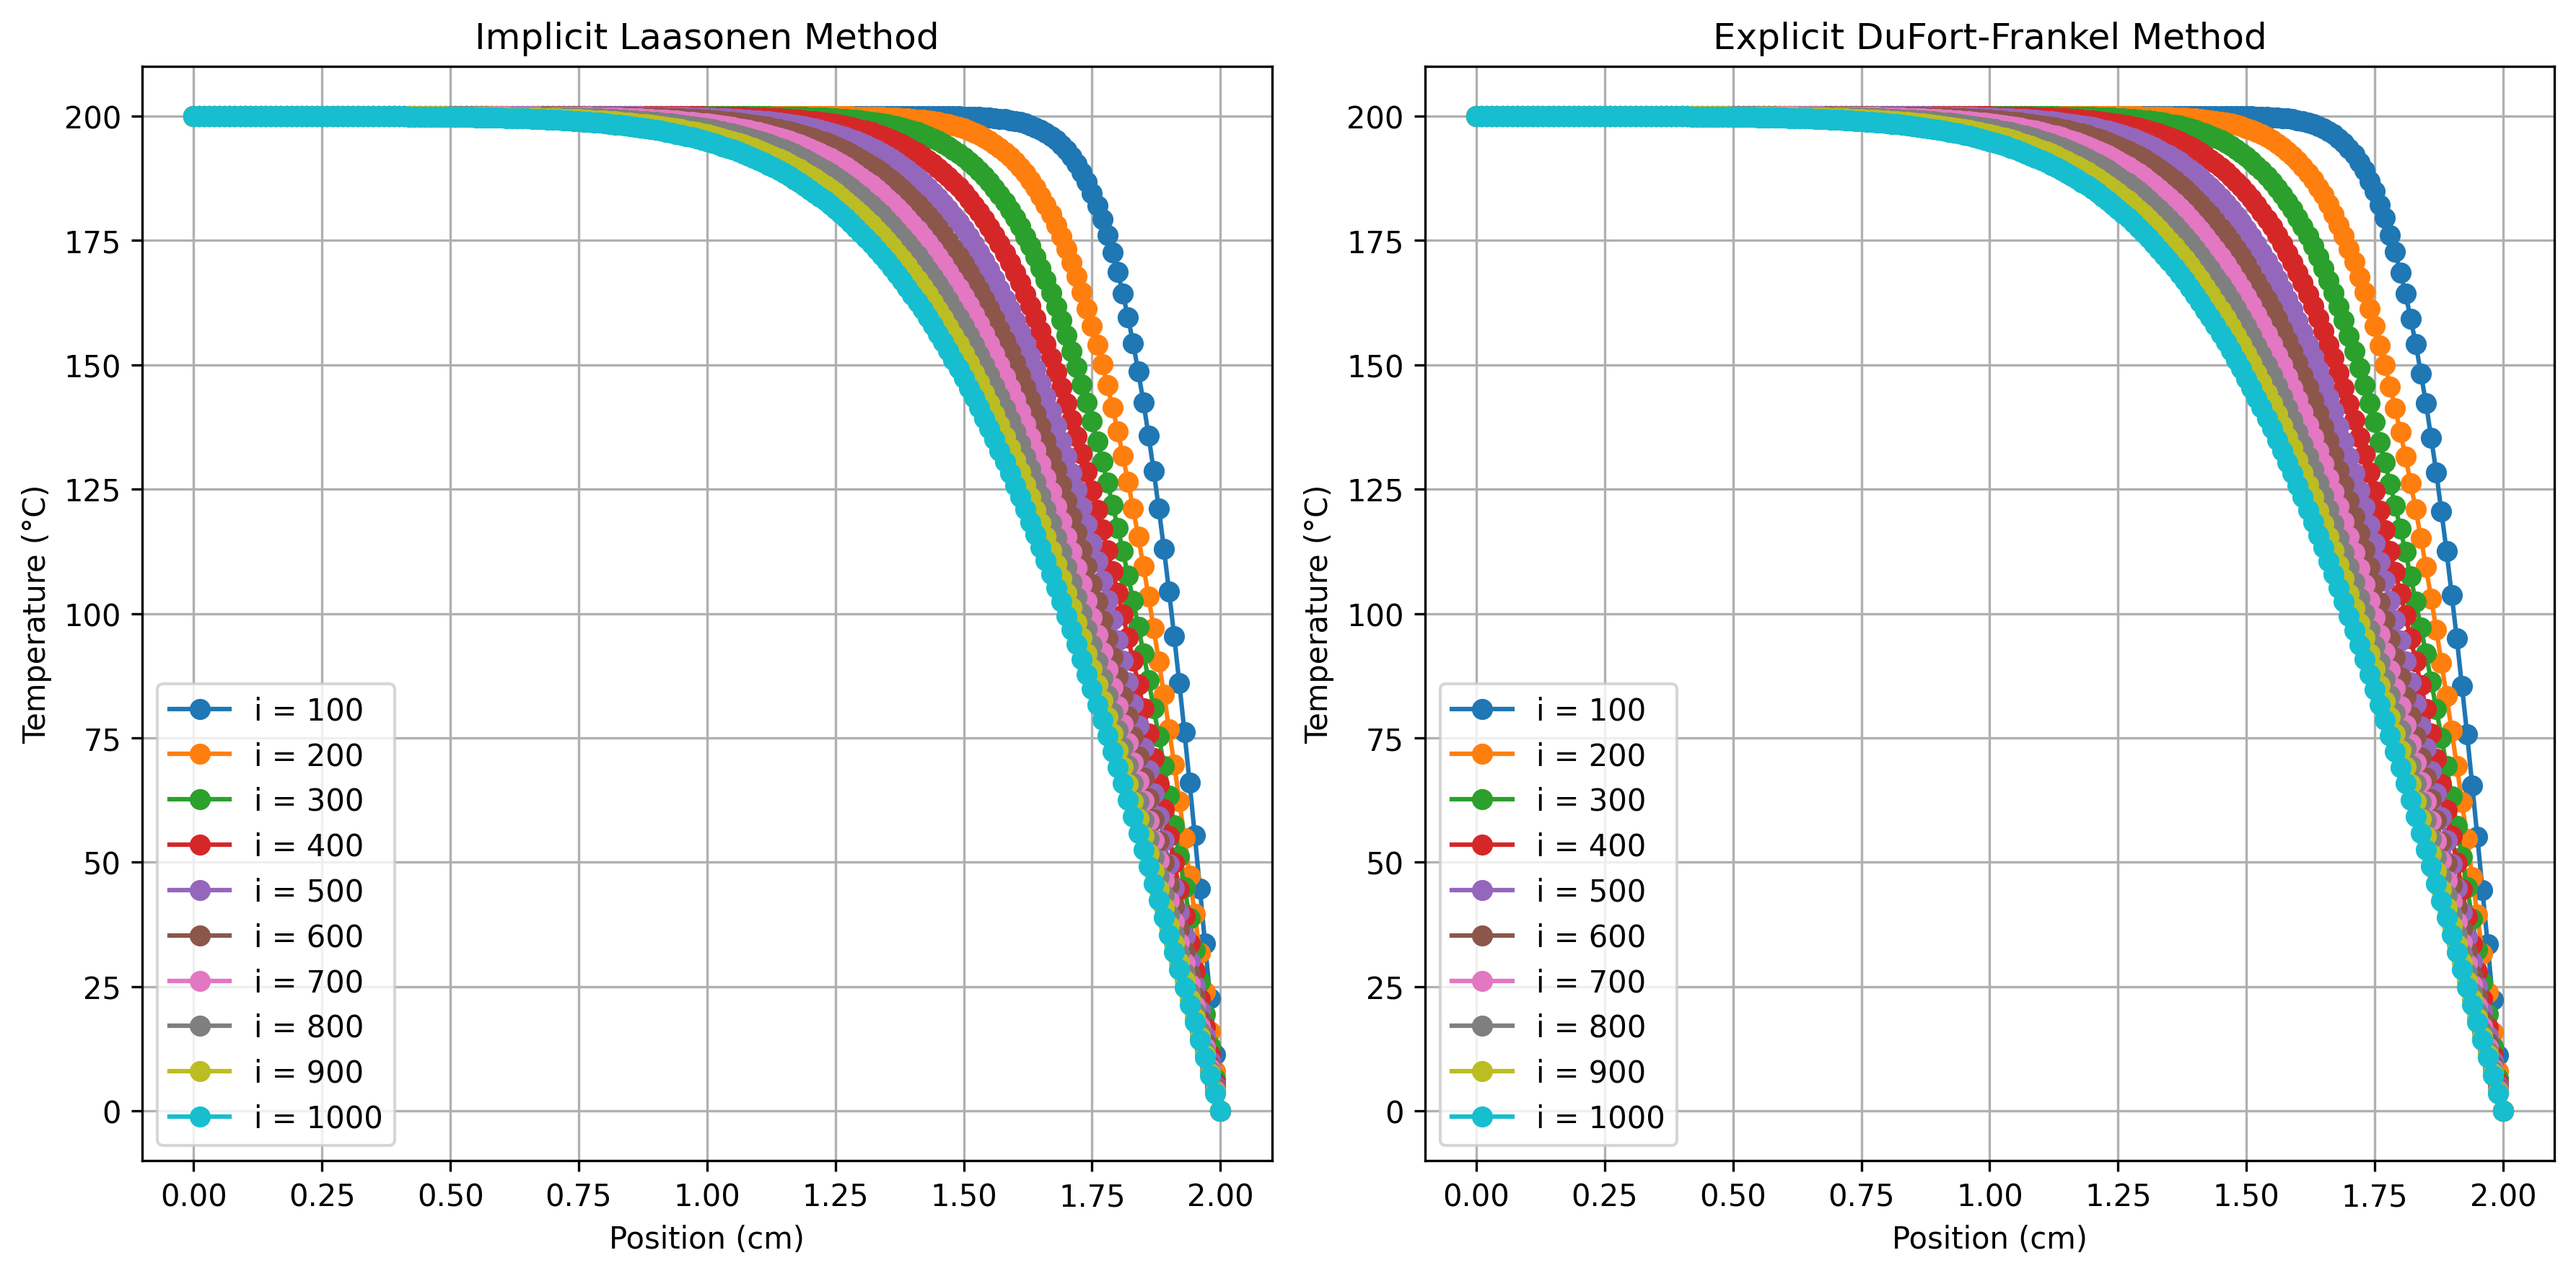

In [5]:
# Parameters for a 10 second simulation of the problem 2, with finer grids and smaller dt
L = 0.02
alpha = 1e-6
k = 2
dx = 0.0001
r = 1.0
T_initial = 200
time_steps = 1000
left_bc_type = 'insulated'
right_bc_type = 'fixed'
right_bc_value = 0
delta_t = (r *  dx**2) / alpha
print(f"Delta t is {delta_t} seconds")

T_laasonen, q_left_laasonen, q_right_laasonen, x, dt = laasonen_solver(
    L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
    right_bc_value=right_bc_value
)

T_dufort, q_left_dufort, q_right_dufort, x, dt = dufort_frankel_solver(
    L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
    right_bc_value=right_bc_value
)

plt.figure(figsize=(12, 6), dpi=300)

for i in [100, 200, 300, 400 ,500, 600, 700, 800, 900, 1000]:
    plt.subplot(1, 2, 1)
    plt.plot(x*100, T_laasonen[:, i], marker='o', label=f'i = {i}')
plt.title('Implicit Laasonen Method')
plt.xlabel('Position (cm)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

for i in [100, 200, 300, 400 ,500, 600, 700, 800, 900, 1000]:
    plt.subplot(1, 2, 2)
    plt.plot(x*100, T_dufort[:, i], marker='o', label=f'i = {i}')
plt.title('Explicit DuFort-Frankel Method')
plt.xlabel('Position (cm)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('temperature_profiles_comparison_for_problem2_finer_grid.png', dpi=300)
plt.show()

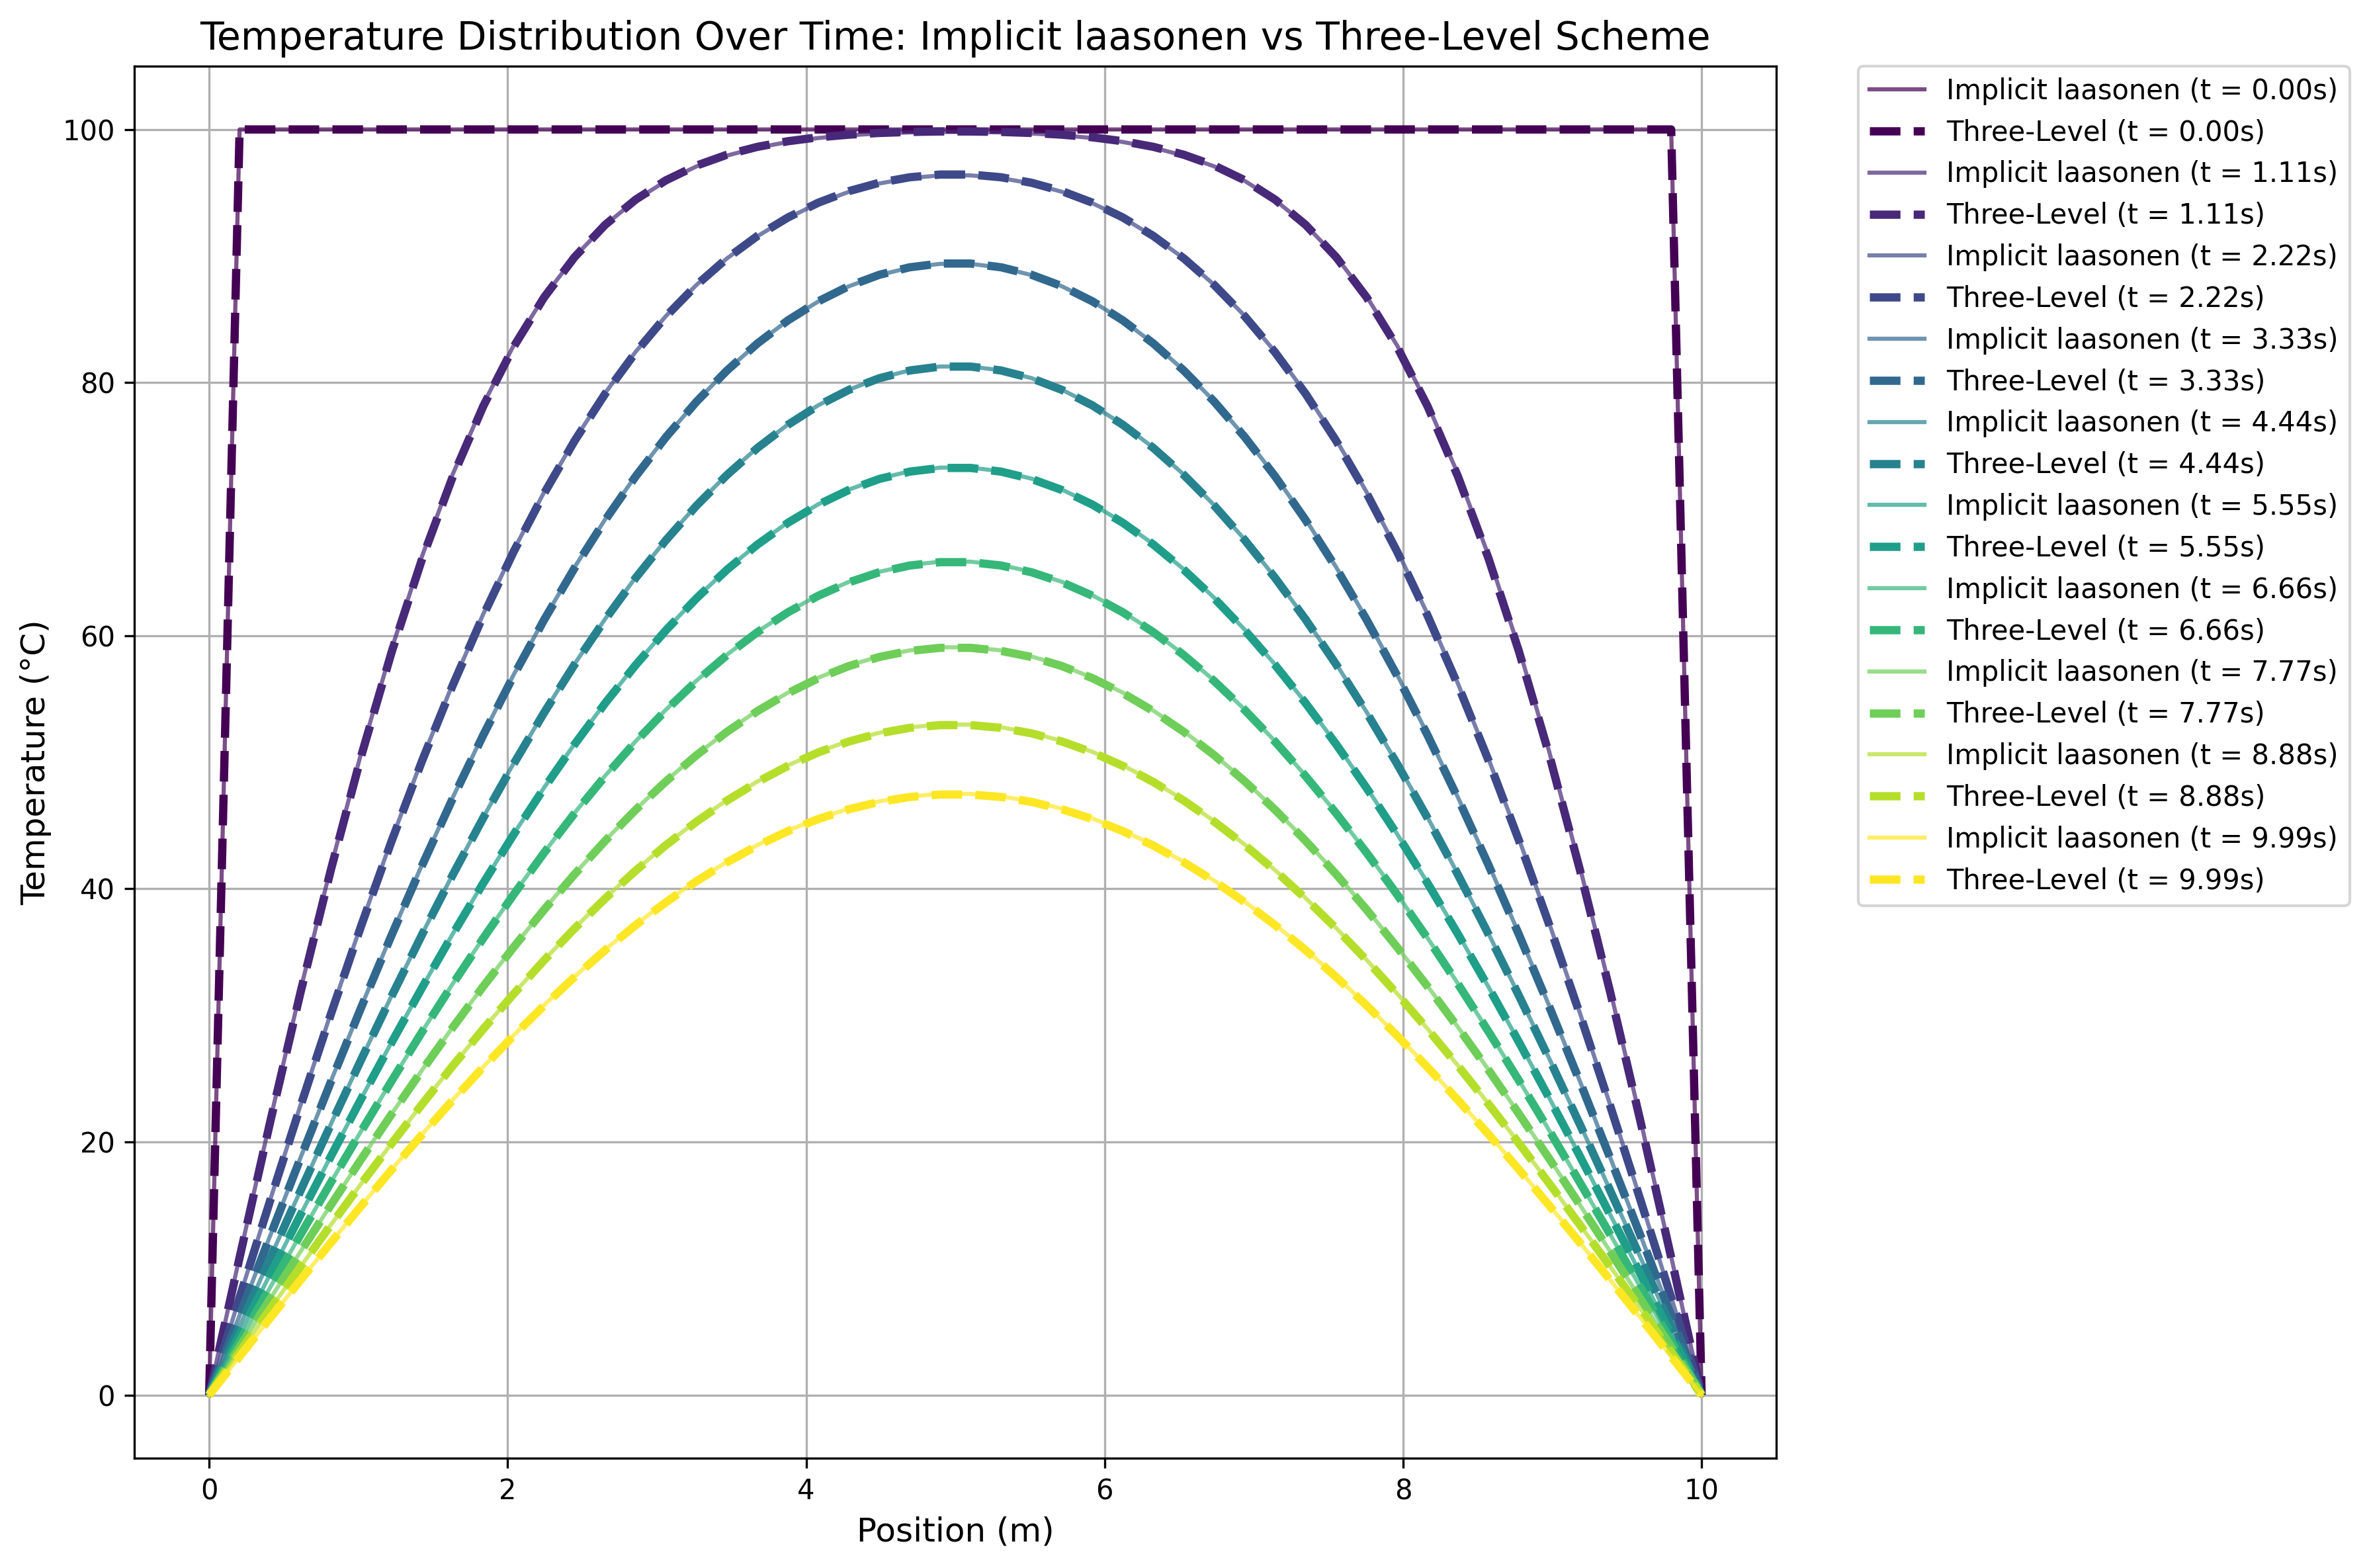

In [6]:
# Problem parameters for comparing methods of problem 1 with 2
alpha = 1
L = 10
k = 1
T_initial = 100
left_bc_type = 'fixed'
right_bc_type = 'fixed'
left_bc_value = 0
right_bc_value = 0
Nx = 50
time_steps = 1000
dx = L / (Nx - 1)
dt = 0.01

if dt > dx**2 / (2 * alpha):
    print("Warning: Time step may be too large for stability!")
    dt = dx**2 / (2 * alpha)

r = dt * alpha / dx**2

T_laasonen, q_left_laasonen, q_right_laasonen, x, dt = laasonen_solver(
    L, alpha, k, dx, r, T_initial, time_steps, left_bc_type, right_bc_type,
    right_bc_value=right_bc_value, left_bc_value=left_bc_value
)

plt.figure(figsize=(12, 8), dpi=300)

num_time_points = 10
time_points = np.linspace(0, time_steps-1, num_time_points, dtype=int)

colors = plt.cm.viridis(np.linspace(0, 1, num_time_points))

for i, n in enumerate(time_points):
    time_label = f"t = {n*dt:.2f}s"
    plt.plot(x, T_laasonen[:, n], color=colors[i], linestyle='-', alpha=0.7, 
             label=f"Implicit laasonen ({time_label})")
    
    plt.plot(x, T_three_level[:, n], color=colors[i], linestyle='--', linewidth=3.0, 
             label=f"Three-Level ({time_label})")

plt.title("Temperature Distribution Over Time: Implicit laasonen vs Three-Level Scheme", fontsize=14)
plt.xlabel("Position (m)", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.grid(True)
plt.savefig('laasonen_Three-Level_comparison.png', dpi=300)
plt.show()